In [1]:
# PyTorch and torchvision
import torch
import torchvision

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print('=3')

=3


In [2]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ~/work/data_augmentation/data
!tar -xf ~/work/data_augmentation/data/images.tar -C ~/work/data_augmentation/data/

--2025-09-02 01:09:22--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/home/jovyan/work/data_augmentation/data/images.tar.2’

images.tar.2        100%[===================>] 756.82M  23.8MB/s    in 45s     

2025-09-02 01:10:07 (17.0 MB/s) - ‘/home/jovyan/work/data_augmentation/data/images.tar.2’ saved [793579520/793579520]



In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

dataset_dir = "~/work/data_augmentation/data/Images/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=32, shuffle=False)
ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

print("=3")

=3


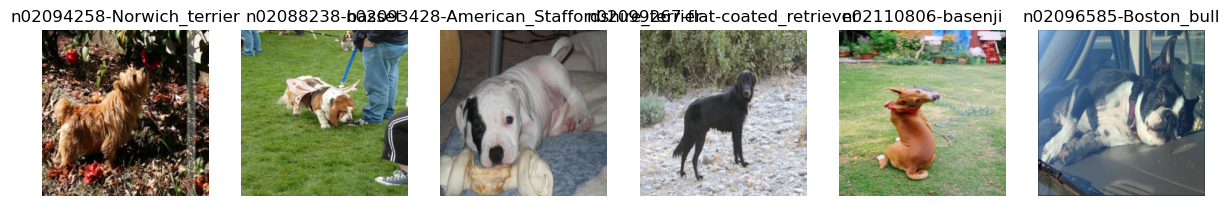

In [5]:
# DataLoader에서 일부 배치 가져오기
def show_examples(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        image = (image * 0.5) + 0.5
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[labels[i].item()])

    plt.show()

# 훈련 데이터 샘플 시각화
show_examples(train_loader, ds_info["class_names"])

In [6]:
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [7]:
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

def augment():
    return transforms.Compose([
        # 크롭으로 위치/스케일 다양화 (너무 작게 자르지 않도록 scale 하한 0.7~0.8 권장)
        transforms.RandomResizedCrop(
            224, scale=(0.75, 1.0), ratio=(0.75, 1.33),
            interpolation=InterpolationMode.BILINEAR
        ),
        # 좌우 반전
        transforms.RandomHorizontalFlip(p=0.5),

        # 작은 각도 회전/이동/스케일/쉬어: 포즈·프레이밍 변화에 강해짐
        transforms.RandomAffine(
            degrees=10,                 # ±10°
            translate=(0.05, 0.05),     # 최대 5% 평행이동
            scale=(0.9, 1.1),           # 0.9~1.1배 스케일
            shear=5,                    # 최대 5° 쉬어
            interpolation=InterpolationMode.BILINEAR
        ),
        
        # 색 변화는 약하게: 강하면 품종의 색 패턴 구분을 해칠 수 있음
        transforms.ColorJitter(
            brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03
        ),
    ])


In [8]:
# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    transform = normalize_and_resize_img()

    if not is_test and with_aug:
        dataset.dataset.transform = transforms.Compose([
            *augment().transforms,
            *transform.transforms
        ])
    else:
        dataset.dataset.transform = transform

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

print('=3')

=3


In [9]:
import torch.nn as nn
import torchvision.models as models

num_classes = len(ds_info["class_names"])
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

model = nn.Sequential(
    resnet50,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(resnet50.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)

print("=3")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s] 


=3


In [10]:
# CrossEntropyLoss = log_softmax + NLLLoss 내부 구현 → 모델 출력은 logits이어야 정상.
# Softmax를 모델 안에 두고 CE를 쓰면 gradient가 눌려 학습이 거의 안 됨.

def make_resnet50(num_classes):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

# 4가지 실험용 동일 아키텍처
resnet50_no_aug = make_resnet50(num_classes)
resnet50_aug   = make_resnet50(num_classes)
resnet50_mixup = make_resnet50(num_classes)
resnet50_cutmix= make_resnet50(num_classes)

In [11]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_loader  = apply_normalize_on_dataset(ds_test,  is_test=True)

print("=3")


=3


In [12]:
%%time
import torch.optim as optim

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

criterion = nn.CrossEntropyLoss() 
opt_no_aug = optim.SGD(resnet50_no_aug.parameters(), lr=0.001)
opt_aug = optim.SGD(resnet50_aug.parameters(), lr=0.1)
opt_mixup = optim.SGD(resnet50_mixup.parameters(), lr=0.001)
opt_cutmix = optim.SGD(resnet50_cutmix.parameters(), lr=0.001)

def train(model, optimizer, train_loader, test_loader, epochs):
    model.to(device)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.56 ms


In [13]:
%%time

history_resnet50_no_aug = train(resnet50_no_aug, opt_no_aug, ds_train_no_aug, ds_test, epochs = 3)

Epoch [1/3], Accuracy: 15.66%


AttributeError: 'int' object has no attribute 'to'

In [14]:
%%time
history_resnet50_aug = train(resnet50_aug, opt_aug, ds_train_aug, ds_test, epochs = 3)

Epoch [1/3], Accuracy: 27.53%


AttributeError: 'int' object has no attribute 'to'

In [15]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

NameError: name 'history_resnet50_no_aug' is not defined

In [ ]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
data_iter = iter(ds_train_no_aug)
images, labels = next(data_iter)

# 첫 번째 배치에서 두 개의 이미지 선택
image_a = images[0].permute(1, 2, 0).numpy()
image_b = images[1].permute(1, 2, 0).numpy()
label_a = labels[0].item()
label_b = labels[1].item()

# 정규화된 텐서를 다시 [0, 1] 범위로 조정
image_a = (image_a * 0.5) + 0.5
image_b = (image_b * 0.5) + 0.5

# 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.axis('off')

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x :', x_min, x_max)
print('y :', y_min, y_max)

In [ ]:
import torch

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min]
    middle_center = image_b[:, y_min:y_max, x_min:x_max]
    middle_right = image_a[:, y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.cpu().numpy())
plt.show()

In [ ]:
import torch.nn.functional as F

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# 예제 실행
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
print(mixed_label)

In [ ]:
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, batch_size, (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

print("=3")

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

# 예제 실행
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img)
plt.show()

print(mixed_label)

In [ ]:
def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)  # (B, num_classes)

    return mixed_imgs, mixed_labels

print('=3')

In [ ]:
import torch
import numpy as np

print(torch.__version__)
print(np.__version__)

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 조정
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
    ])
    return transform(image), label

# 데이터 증강 (좌우 반전, 밝기 조정)
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 값 클리핑
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# 데이터셋 적용
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    dataset = [(normalize_and_resize_img(img, lbl)) for img, lbl in dataset]

    if not is_test and with_aug:
        dataset = [(augment(img, lbl)) for img, lbl in dataset]

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

    if not is_test and with_cutmix:
        dataloader = [(cutmix(img, lbl)) for img, lbl in dataloader]
    else:
        dataloader = [(img, onehot(lbl)) for img, lbl in dataloader]

    return dataloader

print('=3')

In [ ]:
# CutMix를 ds_train_aug에 얹는 최소 유틸
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader

# 소프트(one-hot/확률)와 하드 라벨을 모두 처리하는 CE
class SmartCELoss(nn.Module):
    def __init__(self, label_smoothing: float = 0.0):
        super().__init__()
        self.hard_ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    def forward(self, logits, target):
        if target.dim() == 1:  # 하드 라벨
            return self.hard_ce(logits, target)
        # 소프트 라벨
        logp = F.log_softmax(logits, dim=1)
        return -(target * logp).sum(dim=1).mean()

# get_clip_box가 이미 있으면 그걸 쓰고, 없으면 fallback
def _fallback_clip_box(img_a, img_b):
    _, H, W = img_a.shape
    cx = torch.randint(0, W, (1,)).item()
    cy = torch.randint(0, H, (1,)).item()
    lam = torch.distributions.Beta(1.0, 1.0).sample().item()
    cut_rat = (1. - lam) ** 0.5
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    x1 = max(0, cx - cut_w // 2); x2 = min(W, cx + cut_w // 2)
    y1 = max(0, cy - cut_h // 2); y2 = min(H, cy + cut_h // 2)
    return x1, y1, x2, y2

def _cutmix_batch(x, y, num_classes: int):
    B, C, H, W = x.size()
    # 소프트 타깃 준비
    if y.dim()==1:
        y_soft = F.one_hot(y, num_classes=num_classes).float()
    else:
        y_soft = y.float()
    imgs, tgts = [], []
    use_user_fn = 'get_clip_box' in globals()
    for i in range(B):
        j = torch.randint(0, B, (1,), device=x.device).item()
        if use_user_fn:
            x_min, y_min, x_max, y_max = get_clip_box(x[i], x[j])
        else:
            x_min, y_min, x_max, y_max = _fallback_clip_box(x[i], x[j])
        img = x[i].clone()
        img[:, y_min:y_max, x_min:x_max] = x[j][:, y_min:y_max, x_min:x_max]
        lam = 1.0 - ((x_max-x_min)*(y_max-y_min))/float(W*H)
        tgt = lam*y_soft[i] + (1-lam)*y_soft[j]
        imgs.append(img); tgts.append(tgt)
    return torch.stack(imgs), torch.stack(tgts)

def _infer_num_classes_from_loader(loader, default=120):
    # dataset 클래스 길이 우선, 없으면 배치에서 추론
    ds = getattr(loader, 'dataset', None)
    if ds is not None:
        if hasattr(ds, 'classes'): return len(ds.classes)
        if hasattr(ds, 'class_to_idx'): return len(ds.class_to_idx)
    try:
        xb, yb = next(iter(loader))
        return yb.size(1) if yb.dim()==2 else int(yb.max().item())+1
    except Exception:
        return default

def wrap_loader_with_cutmix(base_loader, num_classes: int):
    """기존 DataLoader의 dataset/파라미터를 그대로 쓰되, collate_fn만 CutMix로 교체."""
    bs = base_loader.batch_size or 64
    nw = base_loader.num_workers
    pm = base_loader.pin_memory
    pw = getattr(base_loader, 'persistent_workers', False)
    ds = base_loader.dataset

    def collate_cutmix(batch):
        imgs, labels = zip(*batch)               # list of (C,H,W) tensor, int
        imgs = torch.stack(imgs, dim=0)
        if torch.is_tensor(labels[0]) and labels[0].dim()>0:
            labels = torch.stack(labels, dim=0)
        else:
            labels = torch.tensor(labels, dtype=torch.long)
        xmix, ymix = _cutmix_batch(imgs, labels, num_classes=num_classes)
        return xmix, ymix

    return DataLoader(
        ds,
        batch_size=bs,
        shuffle=True,                 # train이므로 shuffle=True
        num_workers=nw,
        pin_memory=pm,
        persistent_workers=pw,
        collate_fn=collate_cutmix
    )


In [ ]:
# 소프트(one-hot) 라벨도 지원하도록 정확도 계산만 수정한 train()
def train(model, optimizer, train_loader, test_loader, epochs):
    model.to(device)
    history = {'val_accuracy': [], 'train_accuracy': []}

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)  # 소프트/하드 모두 장치로

            optimizer.zero_grad()
            outputs = model(images)

            # ★ 손실은 SmartCELoss가 소프트/하드 둘 다 처리
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # ★ 정확도는 하드 라벨로 계산
            hard_labels = labels.argmax(1) if labels.dim() == 2 else labels.long()
            _, predicted = outputs.max(1)
            total += hard_labels.size(0)
            correct += (predicted == hard_labels).sum().item()

        train_acc = 100. * correct / total
        history['train_accuracy'].append(train_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%")

        # ---------- Validation ----------
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                # 검증도 하드 라벨로 정확도 계산
                hard_labels = labels.argmax(1) if labels.dim() == 2 else labels.long()
                _, predicted = outputs.max(1)
                total += hard_labels.size(0)
                correct += (predicted == hard_labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history


In [ ]:
# 1) 클래스 수 추론
num_classes = 120

# 2) ds_train_aug를 'CutMix 배치를 내는 DataLoader'로 바꿉니다.
ds_train_aug = wrap_loader_with_cutmix(ds_train_aug, num_classes=num_classes)

# 3) 손실을 소프트 라벨 대응으로 교체 (train()이 전역 criterion을 사용한다면 필수)
criterion = SmartCELoss(label_smoothing=0.0)

# 이제 네가 원하던 형태로 그대로 호출

history_resnet50_cutmix = train(resnet50_cutmix, opt_cutmix, ds_train_aug, ds_test, epochs=3)


In [ ]:
# === MixUp: collate_fn 기반으로 ds_train_aug 위에 얹기 ===
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader

# (이미 정의돼 있지 않다면) 하드/소프트 라벨 모두 처리하는 CE
if 'SmartCELoss' not in globals():
    class SmartCELoss(nn.Module):
        def __init__(self, label_smoothing: float = 0.0):
            super().__init__()
            self.hard_ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        def forward(self, logits, target):
            if target.dim() == 1:   # 하드 라벨
                return self.hard_ce(logits, target)
            # 소프트 라벨
            logp = F.log_softmax(logits, dim=1)
            return -(target * logp).sum(dim=1).mean()

# (없으면) 클래스 수 추론 헬퍼
def _infer_num_classes_from_loader_for_mix(loader, default=120):
    ds = getattr(loader, 'dataset', None)
    if ds is not None:
        if hasattr(ds, 'classes'): return len(ds.classes)
        if hasattr(ds, 'class_to_idx'): return len(ds.class_to_idx)
    try:
        xb, yb = next(iter(loader))
        return yb.size(1) if yb.dim()==2 else int(yb.max().item())+1
    except Exception:
        return default

# MixUp 배치 생성 (라벨이 하드/원핫 모두 지원)
def _mixup_batch(imgs, labels, num_classes: int, alpha: float = 1.0):
    B = imgs.size(0)
    device = imgs.device
    lam = torch.distributions.Beta(alpha, alpha).sample((B,)).to(device) if alpha > 0 else torch.ones(B, device=device)
    idx = torch.randperm(B, device=device)

    xmix = lam.view(B,1,1,1) * imgs + (1.0 - lam).view(B,1,1,1) * imgs[idx]

    if labels.dim() == 1:
        y_soft = F.one_hot(labels, num_classes=num_classes).float()
    else:
        y_soft = labels.float()
    ymix = lam.view(B,1) * y_soft + (1.0 - lam).view(B,1) * y_soft[idx]
    return xmix, ymix

def wrap_loader_with_mixup(base_loader: DataLoader, num_classes: int, alpha: float = 1.0) -> DataLoader:
    """
    기존 DataLoader의 dataset/세팅을 그대로 쓰고, collate_fn만 MixUp으로 교체한 새 로더를 반환.
    """
    bs = base_loader.batch_size or 64
    nw = base_loader.num_workers
    pm = base_loader.pin_memory
    pw = getattr(base_loader, 'persistent_workers', False)
    ds = base_loader.dataset

    def collate_mixup(batch):
        imgs, labels = zip(*batch)  # list of (C,H,W), label
        imgs = torch.stack(imgs, dim=0)
        # labels: int 목록 또는 one-hot 텐서 목록
        if torch.is_tensor(labels[0]) and labels[0].dim() > 0:
            labels = torch.stack(labels, dim=0)
        else:
            labels = torch.tensor(labels, dtype=torch.long)
        return _mixup_batch(imgs, labels, num_classes=num_classes, alpha=alpha)

    return DataLoader(
        ds,
        batch_size=bs,
        shuffle=True,                 # train 이므로 shuffle=True
        num_workers=nw,
        pin_memory=pm,
        persistent_workers=pw,
        collate_fn=collate_mixup
    )


In [ ]:
# 1) num_classes 추론 (검증 로더에서 가져오는 게 안전)
num_classes = _infer_num_classes_from_loader_for_mix(ds_test, default=120)

# 2) ds_train_aug 를 'MixUp 배치를 내는 DataLoader'로 교체
ds_train_aug = wrap_loader_with_mixup(ds_train_aug, num_classes=num_classes, alpha=1.0)

# 3) 손실을 소프트 라벨 대응으로 설정 (train()이 전역 criterion을 참조한다면 필수)
criterion = SmartCELoss(label_smoothing=0.0)

# 4) 모델/옵티마이저가 없으면 만들어 두기(있으면 이 블록은 건너뜀)
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

if 'resnet50_mixup' not in globals():
    resnet50_mixup = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    resnet50_mixup.fc = nn.Linear(resnet50_mixup.fc.in_features, num_classes)
if 'opt_mixup' not in globals():
    opt_mixup = optim.SGD(resnet50_mixup.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# 5) 네가 원하는 스타일로 그대로 학습
%%time
history_resnet50_mixup = train(resnet50_mixup, opt_mixup, ds_train_aug, ds_test, epochs=3)


In [ ]:
# === Generalization comparison: train loss, val loss, and (val - train) gap ===
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0) 손실: 하드(정수)와 소프트(one-hot/확률) 라벨 모두 호환 (MixUp/CutMix용)
class _SmartCELoss(nn.Module):
    def __init__(self, label_smoothing: float = 0.0):
        super().__init__()
        self.hard_ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    def forward(self, logits, target):
        if target.dim() == 1:  # hard labels
            return self.hard_ce(logits, target)
        # soft labels
        return -(target * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

criterion_eval = _SmartCELoss(0.0)

# 1) 보조: 무엇이든(batch list / DataLoader) 순회
def _iter_batches(loader):
    if isinstance(loader, list):
        for b in loader: yield b
    else:
        for b in loader: yield b

# 2) 평가 함수 (평균 loss)
def _evaluate_loss(model, loader):
    model.to(device).eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in _iter_batches(loader):
            xb = xb.to(device)
            yb = yb.to(device) if torch.is_tensor(yb) else torch.tensor(yb, device=device)
            logits = model(xb)
            loss = criterion_eval(logits, yb)
            bs = xb.size(0)
            total += loss.item() * bs
            n += bs
    return total / max(1, n)

# 3) 필요한 경우 MixUp/CutMix 로더 생성 유틸 (없으면 여기서 간단 정의)
def _infer_num_classes_from_loader(loader, default=120):
    try:
        for _, y in _iter_batches(loader):
            return y.size(1) if (torch.is_tensor(y) and y.dim()==2) else default
    except Exception:
        pass
    return default

def _wrap_loader_with_mixup(base_loader, num_classes: int, alpha: float = 1.0):
    bs = getattr(base_loader, "batch_size", None) or 64
    nw = getattr(base_loader, "num_workers", 0)
    pm = getattr(base_loader, "pin_memory", False)
    pw = getattr(base_loader, "persistent_workers", False)
    ds = base_loader.dataset if hasattr(base_loader, "dataset") else None
    if ds is None:
        # base_loader가 리스트면 그대로 사용 (평가 목적엔 불가 → DataLoader 필요)
        raise ValueError("MixUp 로더를 만들려면 원본이 DataLoader여야 합니다.")
    def collate_mix(batch):
        imgs, labels = zip(*batch)
        imgs = torch.stack(imgs, 0)
        if torch.is_tensor(labels[0]) and labels[0].dim() > 0:
            labels = torch.stack(labels, 0)
        else:
            labels = torch.tensor(labels, dtype=torch.long)
        B = imgs.size(0); device = imgs.device
        lam = torch.distributions.Beta(alpha, alpha).sample((B,))
        idx = torch.randperm(B)
        xmix = lam.view(B,1,1,1)*imgs + (1-lam).view(B,1,1,1)*imgs[idx]
        if labels.dim()==1:
            y_soft = F.one_hot(labels, num_classes=num_classes).float()
        else:
            y_soft = labels.float()
        ymix = lam.view(B,1)*y_soft + (1-lam).view(B,1)*y_soft[idx]
        return xmix, ymix
    return DataLoader(ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=pm,
                      persistent_workers=pw, collate_fn=collate_mix)

def _wrap_loader_with_cutmix(base_loader, num_classes: int):
    bs = getattr(base_loader, "batch_size", None) or 64
    nw = getattr(base_loader, "num_workers", 0)
    pm = getattr(base_loader, "pin_memory", False)
    pw = getattr(base_loader, "persistent_workers", False)
    ds = base_loader.dataset if hasattr(base_loader, "dataset") else None
    if ds is None:
        raise ValueError("CutMix 로더를 만들려면 원본이 DataLoader여야 합니다.")
    use_user_box = 'get_clip_box' in globals()
    def _fallback_clip_box(img_a, img_b):
        _, H, W = img_a.shape
        cx = torch.randint(0, W, (1,)).item()
        cy = torch.randint(0, H, (1,)).item()
        lam = torch.distributions.Beta(1.0, 1.0).sample().item()
        cut_rat = (1. - lam) ** 0.5
        cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
        x1 = max(0, cx - cut_w // 2); x2 = min(W, cx + cut_w // 2)
        y1 = max(0, cy - cut_h // 2); y2 = min(H, cy + cut_h // 2)
        return x1, y1, x2, y2
    def collate_cut(batch):
        imgs, labels = zip(*batch)
        imgs = torch.stack(imgs, 0)
        if torch.is_tensor(labels[0]) and labels[0].dim() > 0:
            labels = torch.stack(labels, 0)
        else:
            labels = torch.tensor(labels, dtype=torch.long)
        B, C, H, W = imgs.size()
        if labels.dim()==1:
            y_soft = F.one_hot(labels, num_classes=num_classes).float()
        else:
            y_soft = labels.float()
        out_x, out_y = [], []
        for i in range(B):
            j = torch.randint(0, B, (1,)).item()
            if use_user_box:
                x1, y1, x2, y2 = get_clip_box(imgs[i], imgs[j])
            else:
                x1, y1, x2, y2 = _fallback_clip_box(imgs[i], imgs[j])
            im = imgs[i].clone()
            im[:, y1:y2, x1:x2] = imgs[j][:, y1:y2, x1:x2]
            lam = 1.0 - ((x2-x1)*(y2-y1))/float(W*H)
            tgt = lam*y_soft[i] + (1-lam)*y_soft[j]
            out_x.append(im); out_y.append(tgt)
        return torch.stack(out_x, 0), torch.stack(out_y, 0)
    return DataLoader(ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=pm,
                      persistent_workers=pw, collate_fn=collate_cut)

# 4) 모델 변수명 매핑 — 필요하면 여기서 이름만 바꿔줘
MODEL_VARS = {
    "No Aug":  "resnet50_noaug",   # 예: resnet50_noaug  (없으면 키 자동 스킵)
    "Aug":     "resnet50_aug",     # 예: resnet50_aug
    "MixUp":   "resnet50_mixup",   # 예: resnet50_mixup
    "CutMix":  "resnet50_cutmix",  # 예: resnet50_cutmix
}

# 5) 기준 로더 준비
# - train 로더는 각 실험 분포에 맞춰 구성
# - val 로더는 현재 ds_test/ ds_test_loader 를 그대로 사용
val_loader = ds_test if isinstance(ds_test, (list, DataLoader)) else ds_test  # 그대로 사용
# 기본 train 로더(증강 on/off)는 이미 네가 만든 apply_normalize_on_dataset로 재구성
#  (없으면 기존 ds_train_aug / ds_train_no_aug 를 그대로 사용)
try:
    base_train_noaug = apply_normalize_on_dataset(ds_train, is_test=False, with_aug=False, with_cutmix=False)
    base_train_aug   = apply_normalize_on_dataset(ds_train, is_test=False, with_aug=True,  with_cutmix=False)
except Exception:
    base_train_noaug = ds_train_no_aug if 'ds_train_no_aug' in globals() else ds_train
    base_train_aug   = ds_train_aug    if 'ds_train_aug'    in globals() else ds_train

# 클래스 수 추론(검증 로더 기준이 안전)
num_classes_eval = _infer_num_classes_from_loader(val_loader, default=120)

# MixUp/CutMix 로더 구성(필요한 경우에만 생성)
mixup_train_loader  = None
cutmix_train_loader = None
if isinstance(base_train_aug, DataLoader):
    try:
        mixup_train_loader  = _wrap_loader_with_mixup(base_train_aug,  num_classes=num_classes_eval, alpha=1.0)
        cutmix_train_loader = _wrap_loader_with_cutmix(base_train_aug, num_classes=num_classes_eval)
    except Exception as e:
        print("⚠️ MixUp/CutMix 로더 생성 실패 — base_train_aug가 DataLoader가 아닐 수 있음:", e)

# 6) 모델/로더 매칭
pairs = []
for tag, varname in MODEL_VARS.items():
    if varname in globals():
        model = globals()[varname]
        if tag == "No Aug":
            tr_loader = base_train_noaug
        elif tag == "Aug":
            tr_loader = base_train_aug
        elif tag == "MixUp":
            tr_loader = mixup_train_loader if mixup_train_loader is not None else base_train_aug
        elif tag == "CutMix":
            tr_loader = cutmix_train_loader if cutmix_train_loader is not None else base_train_aug
        else:
            continue
        pairs.append((tag, model, tr_loader))
    # 존재하지 않는 모델 변수는 자동 스킵

if not pairs:
    raise RuntimeError("평가할 모델이 없습니다. MODEL_VARS에서 변수명을 현재 노트북에 맞게 수정하세요.")

# 7) 각 모델에 대해 train/val loss와 gap 계산
results = {}
for tag, model, tr_loader in pairs:
    tl = _evaluate_loss(model, tr_loader)
    vl = _evaluate_loss(model, val_loader)
    gap = vl - tl  # 일반화 갭(낮을수록 일반화가 잘 된 것)
    results[tag] = {"train_loss": tl, "val_loss": vl, "gap": gap}
    print(f"{tag:7s} | train {tl:.4f} | val {vl:.4f} | gap (val-train) {gap:.4f}")

# 8) 시각화
tags = list(results.keys())
train_losses = [results[t]["train_loss"] for t in tags]
val_losses   = [results[t]["val_loss"]   for t in tags]
gaps         = [results[t]["gap"]        for t in tags]

plt.figure(figsize=(8,4))
x = range(len(tags))
w = 0.35
plt.bar([i-w/2 for i in x], train_losses, width=w, label="Train Loss")
plt.bar([i+w/2 for i in x], val_losses,   width=w, label="Val Loss")
plt.xticks(list(x), tags); plt.ylabel("Loss"); plt.title("Train vs Val Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.bar(tags, gaps)
plt.ylabel("Val - Train Loss (Gap)  ↓ better")
plt.title("Generalization Gap by Model")
plt.show()
